In [1]:
#Import some packages to use
from scipy.io import loadmat
import pandas as pd
import numpy as np
import cv2


import matplotlib.pyplot as plt
%matplotlib inline 

#To see our directory
import os
import random
import gc 


In [2]:
#Loading of data
mat_train = loadmat('/Users/maxlim/Grab/cars_train_annos.mat')
mat_test = loadmat('/Users/maxlim/Grab/cars_test_annos.mat')
meta = loadmat('/Users/maxlim/Grab/cars_meta.mat')

labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0])
    
train = list()
for example in mat_train['annotations'][0]:
    label = labels[example[-2][0][0]-1]
    image = example[-1][0]
    train.append((image,label))
    
test = list()
for example in mat_test['annotations'][0]:
    image = example[-1][0]
    test.append(image)


In [3]:
img_width, img_height = 224, 224
nb_train_samples = 8144
nb_validation_samples = 8041
epochs = 10
batch_size = 32
n_classes = 196

In [4]:

validation_size = int(len(train) * 0.10)
test_size = int(len(train) * 0.20)

validation = train[:validation_size].copy()
np.random.shuffle(validation)
train = train[validation_size:]

test = train[:test_size].copy()
np.random.shuffle(test)
train = train[test_size:]


In [5]:
#train.shape

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

from sklearn.model_selection import train_test_split
from tqdm import tqdm

Using TensorFlow backend.


In [7]:
train = pd.read_csv("/Users/maxlim/Grab/Analysis/cars_train.csv")
train.head()
train.columns

train = train.iloc[:1000,:]

In [8]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('/Users/maxlim/Grab/cars_train/'+train['fname'][i],target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1000/1000 [00:13<00:00, 77.35it/s]


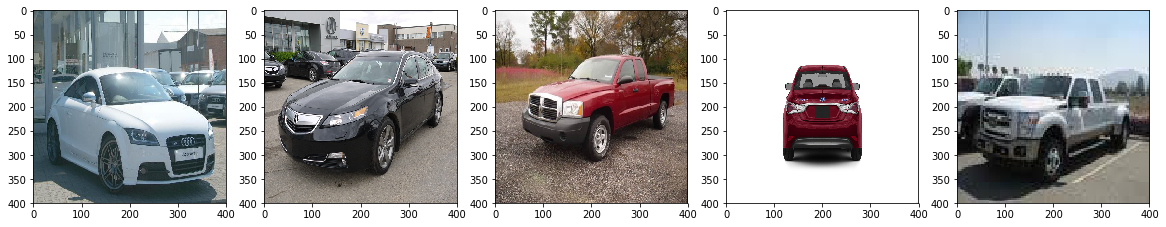

In [9]:
X.shape

plt.figure(figsize = (20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns +1, columns, i +1)
    plt.imshow(X[i])

In [10]:
train['model '][500]

'Mercedes-Benz 300-Class Convertible 1993'

In [11]:
y = np.array(train.drop(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname', 'model '],axis=1))
y.shape

(1000, 196)

In [12]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (1000, 400, 400, 3)
Shape of labels is: (1000, 196)


In [13]:
#Clear list that are useless
del train
del train_image
gc.collect()

10629

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.1)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (900, 400, 400, 3)
Shape of validation images is: (100, 400, 400, 3)
Shape of labels is: (900, 196)
Shape of labels is: (100, 196)


In [15]:
#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

batch_size = 32

In [16]:
model = Sequential()

#Adding 1st Convolution and Pooling Layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
#Dropout 
#only for training data set; (0.2-0.5); 0.2 to start good on large network
#model.add(Dropout(0.2))

#Adding 2nd Convolution and Pooling Layer
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Adding 3rd Convolution and Pooling Layer
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Adding 4th Convolution and Pooling Layer
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Adding 5th Convolution and Pooling Layer
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Flatten
model.add(Flatten())

#Adding Input and Output Layer
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=196,activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 398, 398, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 197, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 128)       0         
__________

In [18]:
#Compile the Neural network
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [20]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [21]:
#Introduced early stopping as callbacks method 
#In the even model can't improve loss for the validation dataset; reduce learning rate 
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [22]:
#The training part
#We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
28/28 [==============================] - 393s 14s/step - loss: 5.2788 - acc: 0.0022 - val_loss: 5.2771 - val_acc: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 280s 10s/step - loss: 5.2588 - acc: 0.0145 - val_loss: 5.2507 - val_acc: 0.0147
Epoch 3/10
28/28 [==============================] - 571s 20s/step - loss: 5.2212 - acc: 0.0134 - val_loss: 5.2610 - val_acc: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 278s 10s/step - loss: 5.2242 - acc: 0.0134 - val_loss: 5.2713 - val_acc: 0.0147
Epoch 5/10
28/28 [==============================] - 380s 14s/step - loss: 5.2061 - acc: 0.0112 - val_loss: 5.2710 - val_acc: 0.0000e+00
Epoch 6/10
28/28 [==============================] - 344s 12s/step - loss: 5.2093 - acc: 0.0134 - val_loss: 5.3541 - val_acc: 0.0294
Epoch 7/10
28/28 [==============================] - 371s 13s/step - loss: 5.2003 - acc: 0.0112 - val_loss: 5.2546 - val_acc: 0.0000e+00
Epoch 8/10
2

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

In [23]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [24]:
loss = History.history['loss']
val_loss = model['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()